# Scratch‑built ViT Captioner

Author: Adam Nguyen

This notebook walks through:
1. **Loading** the MS‑COCO 2014 captions dataset
2. **Exploratory data analysis** with a few univariate plots
3. **Implementing** a compact Vision Transformer encoder + Transformer decoder
4. **Training** the model from scratch
5. **Evaluating** automatic captioning metrics

In [1]:
import random, pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoCaptions

torch.manual_seed(42)


## 1. Load MS‑COCO 2014
Download and extract the annotations + images beforehand.  Pass the directory paths below; COCO helpers will take care of parsing.

In [2]:
import random
import pathlib
from torchvision.datasets import CocoCaptions
from torchvision import transforms

# Paths
COCO_ROOT = pathlib.Path("/home/adanato/Research/STAT4774_Final_Project")
IMG_DIR   = COCO_ROOT / "train2014"
ANN_FILE  = COCO_ROOT / "annotations/captions_train2014.json"

# Pick 5 000 images at random
subset_size        = 20_000
all_image_files    = list(IMG_DIR.glob("*.jpg"))
subset_image_files = random.sample(all_image_files, subset_size)

# Simple resize-crop → tensor transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

class SubsetCocoCaptions(CocoCaptions):
    """COCO sub dataset helps me grab a subset for training"""
    def __init__(self, root, annFile, subset_files, transform=None):
        self.subset_files = subset_files
        self.image_ids    = [int(p.stem.split("_")[-1]) for p in subset_files]
        super().__init__(root, annFile, transform=transform)
        self.ids = self.image_ids                    # restrict COCO IDs

    def __getitem__(self, index):
        return super().__getitem__(index)

# Build the subset dataset
coco_ds = SubsetCocoCaptions(
    root=str(IMG_DIR),
    annFile=str(ANN_FILE),
    subset_files=subset_image_files,
    transform=transform,
)

print(f"Total selected training images: {len(coco_ds):,}")


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Total selected training images: 20,000


## Viewing samples

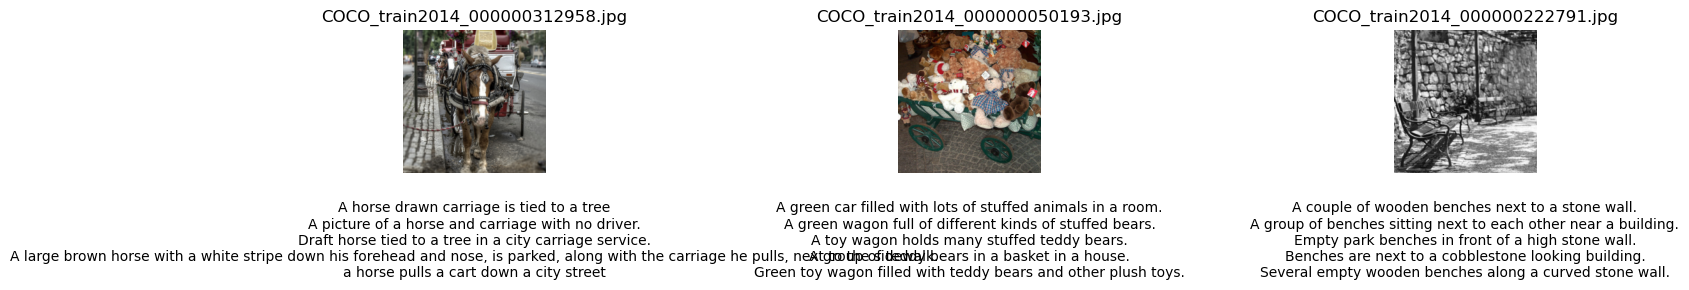

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(42)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, ax in zip(random.sample(range(len(subset_image_files)), 3), axes):
    img, caps = coco_ds[idx]                      # image and its 5 captions
    img_pil    = Image.fromarray(img.mul(255).byte().numpy().transpose(1, 2, 0))

    ax.imshow(img_pil)
    ax.axis("off")
    ax.set_title(subset_image_files[idx].name, fontsize=12)

    ax.text(0.5, -0.2, "\n".join(caps), ha="center", va="top",
            fontsize=10, transform=ax.transAxes)

plt.tight_layout()
plt.show()


### Caption length distribution

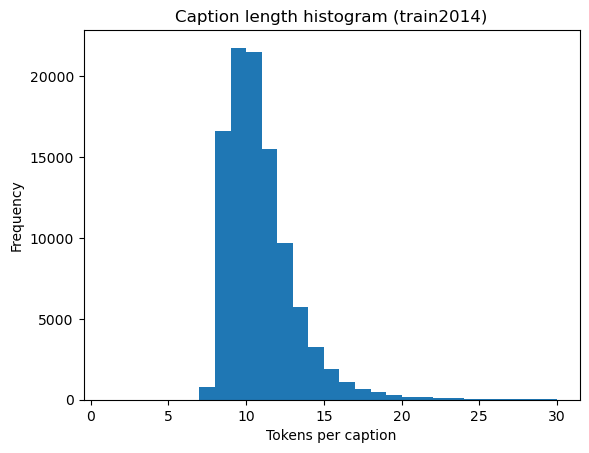

In [4]:
tok_counts = []
for _, caps in coco_ds:
    for c in caps:
        tok_counts.append(len(c.split()))

plt.figure()
plt.hist(tok_counts, bins=range(1, 31))
plt.xlabel('Tokens per caption')
plt.ylabel('Frequency')
plt.title('Caption length histogram (train2014)')
plt.show()


### Top 30 most common tokens

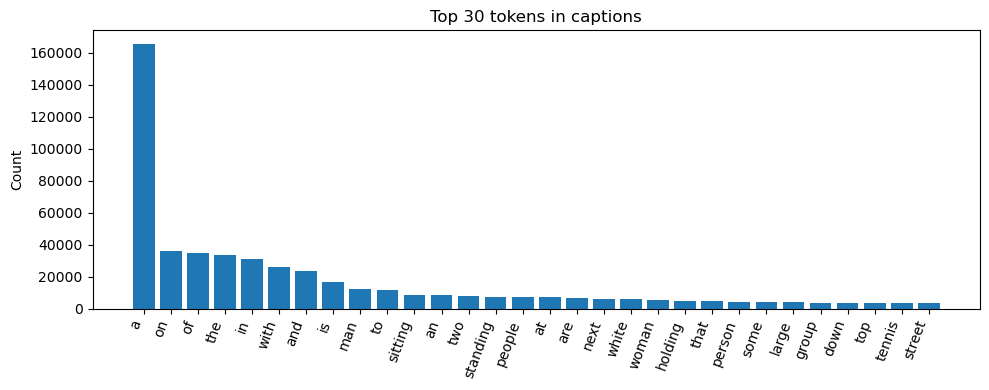

In [5]:
from collections import Counter

counter = Counter()
for _, caps in coco_ds:
    for c in caps:
        counter.update(c.lower().split())

top30 = counter.most_common(30)
words, freqs = zip(*top30)

plt.figure(figsize=(10,4))
plt.bar(range(len(words)), freqs)
plt.xticks(range(len(words)), words, rotation=70, ha='right')
plt.ylabel('Count')
plt.title('Top 30 tokens in captions')
plt.tight_layout()
plt.show()


## 2. Tiny Vision Transformer + Transformer Decoder
Below we implement a very rough image caption model implementation.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#  Embedding and Tiny Encoder
class PatchEmbed(nn.Module):
    def __init__(self, patch_size=32, in_chans=3, embed_dim=512):
        super().__init__()
        assert embed_dim % 8 == 0
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0
        x = self.proj(x)                   # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)   # (B, N, D)
        return x

class TinyViTEncoder(nn.Module):
    def __init__(self, embed_dim=512, depth=4, num_heads=8, patch_size=32):
        super().__init__()
        self.patch_embed = PatchEmbed(patch_size, in_chans=3, embed_dim=embed_dim)
        max_patches = (224 // patch_size)**2 + 1
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, max_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def forward(self, x):
        # x: (B, C, H, W)
        B = x.size(0)
        x = self.patch_embed(x)            # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)     # prepend CLS
        x = x + self.pos_embed[:, : x.size(1)]  # add positional embedding
        x = self.encoder(x)                # (B, N+1, D)
        return x[:, 0]                     # return CLS token only
    
#  Transformer-based image captioner
class TransformerCaptioner(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8,
                 patch_size=32, max_len=512):
        super().__init__()
        self.vision = TinyViTEncoder(embed_dim, depth=4,
                                     num_heads=num_heads,
                                     patch_size=patch_size)

        self.tok_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)

        dec_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=1)
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, imgs, captions):
        # imgs: (B,3,224,224), captions: (B,T)
        B, T = captions.shape
        mem = self.vision(imgs).unsqueeze(1)   # (B,1,D)

        tok = self.tok_embed(captions)         # (B,T,D)
        pos = self.pos_embed(torch.arange(T, device=captions.device))
        tok = tok + pos.unsqueeze(0)           # add positional

        # causal mask to prevent peeking future tokens
        causal = torch.triu(torch.ones(T, T, device=captions.device),
                            diagonal=1).bool()
        dec = self.decoder(tok, mem, tgt_mask=causal)  # (B,T,D)
        return self.head(self.ln(dec))         # (B,T,vocab_size)

## 3. Training Setup
The training loop processes each minibatch by selecting the first caption per image, tokenizing it with the BERT tokenizer to a fixed length of 30 tokens, and creating input and target sequences shifted by one token. Images are encoded by the ViT, the decoder predicts the next tokens from the input sequence, and cross-entropy loss is computed against the target sequence while ignoring padding. Gradients are back-propagated and the Adam optimizer updates the model parameters. The average loss over all samples is returned as the epoch loss to monitor convergence.


In [7]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for imgs, caps_all in loader:
        imgs = imgs.to(device)  # image batch

        # get first caption and lowercase
        caps_str = [c[0].lower() for c in caps_all]

        # tokenize to fixed length
        caps_tok = [
            tokenizer.encode(
                s,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=40
            )
            for s in caps_str
        ]
        caps_tok = torch.tensor(caps_tok, dtype=torch.long, device=device)

        # prepare inputs and targets
        caps_in  = caps_tok[:, :-1]
        targets  = caps_tok[:, 1:]

        # forward pass
        logits = model(imgs, caps_in)  # (B, T-1, V)

        # flatten for CrossEntropyLoss
        flat_logits = logits.reshape(-1, logits.size(-1))
        flat_targets = targets.reshape(-1)

        loss = criterion(flat_logits, flat_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


/home/adanato/miniconda3/envs/caption310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Evaluation Setup
This section sets up the greedy decoding and metric computation (BLEU).

In [8]:
import evaluate
import torch

# Greedy decode a single image into a caption
def greedy_decode(model, img, tokenizer, max_len=30, device="cuda"):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)               # batchify single image
        enc = model.vision(img)                         # encode image

        # start token
        start_id = tokenizer.bos_token_id or tokenizer.cls_token_id
        generated = [start_id]

        for _ in range(max_len):
            inp = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
            pos = model.pos_embed(torch.arange(inp.size(1), device=device))
            logits = model.head(model.decoder(model.tok_embed(inp) + pos, enc.unsqueeze(1)))
            next_tok = logits[0, -1].argmax().item()
            if next_tok == tokenizer.eos_token_id:
                break
            generated.append(next_tok)

        return tokenizer.decode(generated[1:], skip_special_tokens=True)

device = torch.device("cuda")
bleu_metric = evaluate.load("bleu")   # load BLEU metric

# Compute BLEU over up to max_samples images
def compute_metrics(model, loader, max_samples=100):
    preds, refs = [], []
    model.eval()

    with torch.no_grad():
        for imgs, caps_all in loader:
            imgs = imgs.to(device)
            for img, caps in zip(imgs, caps_all):
                preds.append(greedy_decode(model, img, tokenizer, device=device))
                refs.append([caps[0]])    # use first caption as reference
                if len(preds) >= max_samples:
                    break
            if len(preds) >= max_samples:
                break

    return bleu_metric.compute(predictions=preds, references=refs)


## Training & Eval

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Custom collate_fn to avoid padding lists of captions
def caption_collate_fn(batch):
    imgs, caps_lists = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, list(caps_lists)

# model / optimizer / dataloader
vocab_size = len(tokenizer)
model = TransformerCaptioner(vocab_size=vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion  = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

batch_size   = 64
train_loader = DataLoader(
    coco_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=caption_collate_fn,   # use the custom collate
)

# training loop
num_epochs = 10

# storage for plotting
train_losses     = []
bleu1_list       = []
bleu2_list       = []
bleu3_list       = []
bleu4_list       = []
corpus_bleu_list = []

# training + evaluation loop
for epoch in tqdm(range(1, num_epochs + 1), desc="Training", unit="epoch"):
    model.train()
    loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(loss)
    tqdm.write(f"Epoch {epoch}/{num_epochs} — loss: {loss:.4f}")

    # compute BLEU on a subset
    bleu = compute_metrics(model, train_loader)    
    b1, b2, b3, b4 = bleu["precisions"][:4]
    cb = bleu["bleu"]

    bleu1_list.append(b1)
    bleu2_list.append(b2)
    bleu3_list.append(b3)
    bleu4_list.append(b4)
    corpus_bleu_list.append(cb)

    tqdm.write(f"  BLEU-1…4: {[b1, b2, b3, b4]}")
    tqdm.write(f"  corpus BLEU: {cb:.4f}")




Training:   0%|          | 0/10 [02:20<?, ?epoch/s]

Epoch 1/10 — loss: 4.9378


Training:  10%|█         | 1/10 [02:24<21:38, 144.31s/epoch]

  BLEU-1…4: [0.12333333333333334, 0.0175, 0.00631578947368421, 0.0016666666666666668]
  corpus BLEU: 0.0123


Training:  10%|█         | 1/10 [04:44<21:38, 144.31s/epoch]

Epoch 2/10 — loss: 3.8118


Training:  20%|██        | 2/10 [04:48<19:14, 144.30s/epoch]

  BLEU-1…4: [0.13174603174603175, 0.016201117318435754, 0.0029585798816568047, 0.0006289308176100629]
  corpus BLEU: 0.0079


# Plotting the training and evaluation results

In [ ]:
# Plot training loss and all BLEU curves together
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses,     label="Train Loss")
plt.plot(range(1, num_epochs + 1), bleu1_list,       label="BLEU-1")
plt.plot(range(1, num_epochs + 1), bleu2_list,       label="BLEU-2")
plt.plot(range(1, num_epochs + 1), bleu3_list,       label="BLEU-3")
plt.plot(range(1, num_epochs + 1), bleu4_list,       label="BLEU-4")
plt.plot(range(1, num_epochs + 1), corpus_bleu_list, label="Corpus BLEU")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Loss & BLEU Scores over Epochs")
plt.legend()
plt.show()


# Show qualitative samples: image on left, reference & prediction on right
print("\nQualitative samples of 5 images:\n")
with torch.no_grad():
    for imgs, caps_all in train_loader:
        imgs = imgs.to(device)
        # create a 5×2 grid for images and captions
        fig, axes = plt.subplots(5, 2, figsize=(10, 25))
        
        for i, (img, caps) in enumerate(zip(imgs[:5], caps_all[:5])):
            # Left column: display the image
            ax_img = axes[i, 0]
            img_np = img.cpu().permute(1, 2, 0).clamp(0, 1).numpy()
            ax_img.imshow(img_np)
            ax_img.axis('off')

            # Right column: print reference and prediction
            ax_txt = axes[i, 1]
            pred = greedy_decode(model, img, tokenizer, device=device)
            ref  = caps[0]  # first ground-truth caption
            text = f"Ref: {ref}\n\nPred: {pred}"
            ax_txt.text(0, 0.5, text, wrap=True, va="center")
            ax_txt.axis('off')
        
        plt.tight_layout()
        plt.show()
        break
